# Facial expression recognition CNN using Pytorch
#### Warning: **Takes way too long to run!!!**

I found a dataset on Kaggle of facial expressions, fer2013. The dataset comprises grayscale images of faces, each with a resolution of 48x48 pixels. The images have undergone automatic alignment to ensure the face is approximately centered and occupies a consistent amount of space across all samples. The objective is to classify each face into one of seven emotion categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral) based on the displayed facial expression.

In the "train.csv" file, there are two columns: "emotion" and "pixels." The "emotion" column contains numeric codes ranging from 0 to 6, indicating the present emotion in the corresponding image. The "pixels" column contains quoted strings for each image, representing space-separated pixel values in row-major order. The "test.csv" file only includes the "pixels" column, and the challenge is to predict the "emotion" column.

#### Download links: 
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
https://www.kaggle.com/datasets/msambare/fer2013/data

In [3]:
!pip install SMOTE #install SMOTE

DEPRECATION: lightning-lite 1.8.0.post1 has a non-standard dependency specifier torch>=1.9.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of lightning-lite or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.8.0.post1 has a non-standard dependency specifier torch>=1.9.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release 

## Data

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset

data = pd.read_csv('/Users/Anyah1/Downloads/fer2013 2.csv')

emotion_labels = {
    0: 'Anger',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

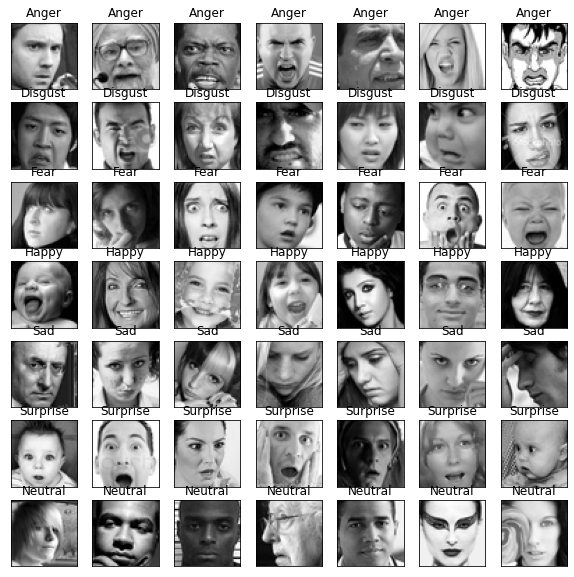

In [33]:
fig = plt.figure(1, (10,10))
img_id = 0
for label in sorted(data.emotion.unique()):
    for j in range(7):
        px = data[data.emotion == label].pixels.iloc[img_id]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        img_id += 1
        ax = plt.subplot(7, 7, img_id)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_labels[label])   

## Model

In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 7)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = self.maxpool1(x)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = self.maxpool2(x)
        
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.softmax(x, dim=1)


pixels = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32') / 255.0)
X = np.vstack(pixels.values)
y = data['emotion']

smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train).view(-1, 1, 48, 48)
y_train_tensor = torch.LongTensor(y_train.values)
X_val_tensor = torch.Tensor(X_val).view(-1, 1, 48, 48)
y_val_tensor = torch.LongTensor(y_val.values)
X_test_tensor = torch.Tensor(X_test).view(-1, 1, 48, 48)
y_test_tensor = torch.LongTensor(y_test.values)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 40
print_frequency = 5

for epoch in range(num_epochs):
    model.train()

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % print_frequency == 0:
        # Evaluate the model on the validation set
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        #validation loss and accuracy for epochs in multiples of 5
        val_loss /= len(val_dataloader)
        val_accuracy = correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4%}')


/Users/Anyah1/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Epoch 5/40, Validation Loss: 1.5708, Validation Accuracy: 59.2504%
Epoch 10/40, Validation Loss: 1.5251, Validation Accuracy: 63.5280%
Epoch 15/40, Validation Loss: 1.4950, Validation Accuracy: 66.8786%
Epoch 20/40, Validation Loss: 1.4812, Validation Accuracy: 68.3618%
Epoch 25/40, Validation Loss: 1.4750, Validation Accuracy: 68.9578%
Epoch 30/40, Validation Loss: 1.4655, Validation Accuracy: 69.8053%
Epoch 35/40, Validation Loss: 1.4634, Validation Accuracy: 70.0305%
Epoch 40/40, Validation Loss: 1.4688, Validation Accuracy: 69.4742%


## Classification report

In [6]:
import seaborn as sns
from sklearn.metrics import classification_report

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

print(classification_report(true_labels, predicted_labels, target_names=list(emotion_labels.values())))

              precision    recall  f1-score   support

       Anger       0.59      0.66      0.63      1797
     Disgust       0.97      0.97      0.97      1770
        Fear       0.72      0.50      0.59      1803
       Happy       0.69      0.73      0.71      1776
         Sad       0.60      0.51      0.55      1857
    Surprise       0.79      0.85      0.82      1851
     Neutral       0.55      0.66      0.60      1731

    accuracy                           0.70     12585
   macro avg       0.70      0.70      0.70     12585
weighted avg       0.70      0.70      0.69     12585



## Confusion Matrix

Looking at the confusion matrix tells me that this model performed fairly decent overall. Anger and Surprise having a significant percentage of positive instances correctly predicted. However, there is room for improvement in terms of precision, with fear and sadness having the lowest percentage of correctly predicted instances

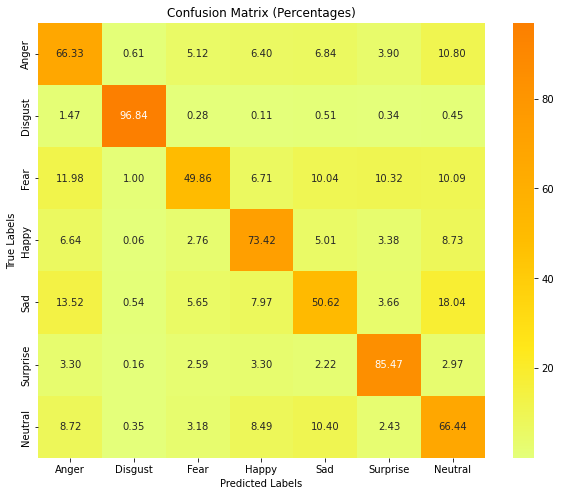

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels, predicted_labels)

conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Wistia', xticklabels=list(emotion_labels.values()), yticklabels=list(emotion_labels.values()))
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Test Cases

I've conducted three test cases with a few images that were used on other models in this project. The images I used were sad.jpg, happy.jpg, and surprised.jpg. The model achieved only one correct prediction out of the three images, specifically in the last test case for surprise. Given its accuracy of 70%, this result aligns with expectations, reflecting the model's relatively low performance. Consequently, the outcome wasn't particularly surprising.

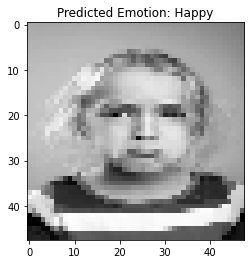

In [29]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import torchvision.transforms as T
import matplotlib.image as mpimg


img_path = '/Users/Anyah1/MOOD/Research/Images/sad.jpg'
img = mpimg.imread(img_path)
img_tensor = torch.from_numpy(img.copy())

transforms = torch.nn.Sequential(
    T.Resize((48, 48)),
    T.Grayscale(num_output_channels=1)
)

img_tensor = transforms(img_tensor.permute(2, 0, 1)) / 255

output = model(img_tensor.type(torch.FloatTensor).unsqueeze(dim=0).to(DEVICE))
predicted_label = int(torch.argmax(output))
predicted_emotion = emotion_labels[predicted_label]

plt.imshow(img_tensor.squeeze(), cmap='gray')
plt.title(f'Predicted Emotion: {predicted_emotion}')
plt.show()

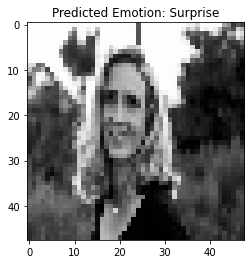

In [30]:
img_path = '/Users/Anyah1/MOOD/Research/Images/happy.jpg'
img2 = mpimg.imread(img_path)
img_tensor = torch.from_numpy(img2.copy())

transforms = torch.nn.Sequential(
    T.Resize((48, 48)),
    T.Grayscale(num_output_channels=1)
)

img_tensor = transforms(img_tensor.permute(2, 0, 1)) / 255

output = model(img_tensor.type(torch.FloatTensor).unsqueeze(dim=0).to(DEVICE))
predicted_label = int(torch.argmax(output))
predicted_emotion = emotion_labels[predicted_label]

plt.imshow(img_tensor.squeeze(), cmap='gray')
plt.title(f'Predicted Emotion: {predicted_emotion}')
plt.show()

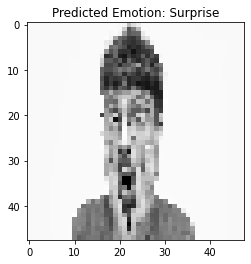

In [32]:
img_path = '/Users/Anyah1/MOOD/Research/Images/surprised.jpg'
img3 = mpimg.imread(img_path)
img_tensor = torch.from_numpy(img3.copy())

transforms = torch.nn.Sequential(
    T.Resize((48, 48)),
    T.Grayscale(num_output_channels=1)
)

img_tensor = transforms(img_tensor.permute(2, 0, 1)) / 255

output = model(img_tensor.type(torch.FloatTensor).unsqueeze(dim=0).to(DEVICE))
predicted_label = int(torch.argmax(output))
predicted_emotion = emotion_labels[predicted_label]

plt.imshow(img_tensor.squeeze(), cmap='gray')
plt.title(f'Predicted Emotion: {predicted_emotion}')
plt.show()

## Comparative analysis

Compared to 'CV2 using Facial Emotion Recognition (FER)', this model's performance wasn't great. cv2 had a higher rate of correct predictions made. PyTorch not scale well to larger datasets and can be slow when dealing with large volumes of data.

## Reflection

I perfer using Keras and tensorflow over Pytorch when it comes to CNNs. The training is very slow compared to Keras. I've had more trouble getting this one working, and ultimately, I feel that Keras was easier to use than Pytorch.